# Salary Predictions Based on Job Descriptions

### Problem Definition

As a Data Scientist in the recruitment industry, my goal is to build a system to predict salaries for a new set of job postings based on data provided on a set of historic job postings that include salaries.

Two CSV data files are available as a basis for training a machine learning model:

• train_features.csv: Each row represents metadata for an individual job posting.
The “jobId” column represents a unique identifier for the job posting. The remaining columns describe features of the job posting.
• train_salaries.csv: Each row associates a “jobId” with a “salary”.

The data upon which predictions should be made are stored in a further CSV data file:

• test_features.csv: Similar to train_features.csv, each row represents metadata for an individual job posting.

The output of my system should be a CSV file entitled test_salaries.csv where each row has the following format:

jobId, salary

### Library Imports

In [555]:
# Importing base libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Importing scikit-learn pre-processing libraries.
from sklearn.preprocessing import LabelEncoder


# Importing scikit-learn machine learning libraries.



# Author information.
__author__ = "Ross MacDonald"
__email__ = "ross.macdonald@technologist.com"

 ### Reusable Functions

In [556]:
# Load CSV data file with completion dialogue and shape confirmation.
def load_file(file):
    df =  pd.read_csv(file)
    shape = df.shape
    print("Data file is loaded, the shape of the dataset = {}".format(shape))
    return df

# Show first and last lines (number of lines defined by x) of a defined dataframe (df).
def ends(df, x):
    print('{} rows x {} columns'.format(np.shape(df)[0],np.shape(df)[1]))
    return df.head(x).append(df.tail(x))

# Produce plots for feature versus target.
def plot_feature(df, feature, target):
    fig = plt.figure(figsize=(16,16))

    
    # Produce ditribution plot of feature.
    plt.subplot(2,1,1)
    plt.tight_layout()
    if df[feature].dtype=='int64' or df[feature].dtype =='float64':
        sns.distplot(df[feature])
    else:
        df[feature].value_counts().sort_values().plot()
    plt.title('Distribution of '+feature, fontsize=13, weight='bold')
    plt.xlabel(feature, fontsize=13, weight='bold')
    plt.ylabel('Counts', fontsize=13, weight='bold')
    if feature =='companyId':
        plt.xticks(rotation=90)
    else:
        plt.xticks(rotation=45)
    
    # Produce plot that shows feature correlation with target.
    plt.subplot(2,1,2)
    plt.tight_layout()
    if df[feature].dtype=='int64' or df[feature].dtype=='float64':
        sns.regplot(x=feature,y=target,data=df)
    else:
        order = df.groupby(feature).mean().sort_values(target).reset_index()[feature].values
        sns.boxplot(x=feature,y=target,data=df,order=order)
    plt.title('Correlation of '+feature+' with '+ target, fontsize=13, weight='bold')
    plt.xlabel(feature, fontsize=13, weight='bold')
    plt.ylabel(target, fontsize=13, weight='bold')
    if feature =='companyId':
        plt.xticks(rotation=90)
    else:
        plt.xticks(rotation=45)
        
# Function to eliminate redundant pairs to generate top correlation pairs.
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

# Generate the top correlations from the dataframe passed in.
def get_top_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    print('Top '+ str(n) +' Correlated Pairs')
    return au_corr[0:n]

### Load the Data

In [557]:
# Load the data into pandas dataframes (csv files for training and test data).
train_feature_df = load_file('data/train_features.csv')
train_target_df = load_file('data/train_salaries.csv')
test_df = load_file('data/test_features.csv')

Data file is loaded, the shape of the dataset = (1000000, 8)
Data file is loaded, the shape of the dataset = (1000000, 2)
Data file is loaded, the shape of the dataset = (1000000, 8)


In [558]:
# Merge the data on jobId to get a single training dataset (includes features and target).
train_df = pd.merge(train_feature_df,train_target_df,how="inner",on="jobId")

In [559]:
# Initial check of top 10 rows of train_df to confirm load and get an initial view on data / types.
train_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31,113
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70,73
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,31
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68,104


In [560]:
# Initial check of top 10 rows of test_feature_df to confirm load and get an initial view on data / types.
test_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44
5,JOB1362685407692,COMP40,CTO,MASTERS,COMPSCI,FINANCE,6,23
6,JOB1362685407693,COMP32,SENIOR,MASTERS,COMPSCI,SERVICE,6,32
7,JOB1362685407694,COMP11,CEO,BACHELORS,BIOLOGY,SERVICE,9,73
8,JOB1362685407695,COMP39,MANAGER,DOCTORAL,PHYSICS,HEALTH,6,78
9,JOB1362685407696,COMP22,VICE_PRESIDENT,NONE,NONE,AUTO,23,97


In [561]:
# Get information on the train_feature_df dataframe. Ensure data types and number of entries per column are as expected.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [562]:
# Get information on the train_feature_df dataframe. Ensure data types and number of entries per column are as expected.
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


### Clean the Data

In [563]:
# Check for duplicate rows in train_df.
print("Number of duplicated rows = {}".format(train_df.duplicated().sum()))

Number of duplicated rows = 0


In [564]:
# Check for duplicate rows in train_df.
print("Number of duplicated rows = {}".format(train_df.duplicated().sum()))

Number of duplicated rows = 0


In [565]:
# Check for null values in the columns of train_df.
train_df.isnull().sum().to_frame('Null Entries')

,Null Entries
jobId,0
companyId,0
jobType,0
degree,0
major,0
industry,0
yearsExperience,0
milesFromMetropolis,0
salary,0


In [566]:
# Check for null values in the columns of test_df.
test_df.isnull().sum().to_frame('Null Entries')

,Null Entries
jobId,0
companyId,0
jobType,0
degree,0
major,0
industry,0
yearsExperience,0
milesFromMetropolis,0


##### There are no duplicates or null entries in the data, so no need to drop rows / entries or subsitute any values. 

In [567]:
# Get the column names for numerical columns from train_df to enable us to filter for invalid values. 
print(train_df.select_dtypes(include=['float64', 'int64']).columns.values)

['yearsExperience' 'milesFromMetropolis' 'salary']


In [568]:
# Having found the column names for numerical columns from train_df, find rows that contain invalid values (i.e. <0 or <=0).
print(train_df[(train_df['yearsExperience'] < 0) | (train_df['milesFromMetropolis'] < 0) | (train_df['salary'] <= 0)])

                   jobId companyId         jobType       degree        major  \
30559   JOB1362684438246    COMP44          JUNIOR     DOCTORAL         MATH   
495984  JOB1362684903671    COMP34          JUNIOR         NONE         NONE   
652076  JOB1362685059763    COMP25             CTO  HIGH_SCHOOL         NONE   
816129  JOB1362685223816    COMP42         MANAGER     DOCTORAL  ENGINEERING   
828156  JOB1362685235843    COMP40  VICE_PRESIDENT      MASTERS  ENGINEERING   

       industry  yearsExperience  milesFromMetropolis  salary  
30559      AUTO               11                    7       0  
495984      OIL                1                   25       0  
652076     AUTO                6                   60       0  
816129  FINANCE               18                    6       0  
828156      WEB                3                   29       0  


In [569]:
# Remove the rows that contain invalid data from the train_df dataframe (i.e. salary was invalid in all cases, thus only include rows with salaries more than 0).
train_df = train_df[train_df.salary > 0]

In [570]:
# Check dataframe information to confirm that the expected rows have been dropped.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  999995 non-null object
companyId              999995 non-null object
jobType                999995 non-null object
degree                 999995 non-null object
major                  999995 non-null object
industry               999995 non-null object
yearsExperience        999995 non-null int64
milesFromMetropolis    999995 non-null int64
salary                 999995 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [571]:
# Reset the index of train_df after dropping the invalid values and print head and tail (using function ends) to confirm.
# reindex. Makes rows sequential to prevent any misunderstanding in subsequent analysis.
train_df = train_df.reset_index(drop=True)
ends(train_df, 3)

999995 rows x 9 columns


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
999992,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999993,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149
999994,JOB1362685407686,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11,88


##### Invalid numerical entries have been dropped from the train_df dataframe, ensuring only valid data informs the prediction model / system. Index has been reset to prevent any misunderstanding (due to non-sequential rows in data) in any further analysis.

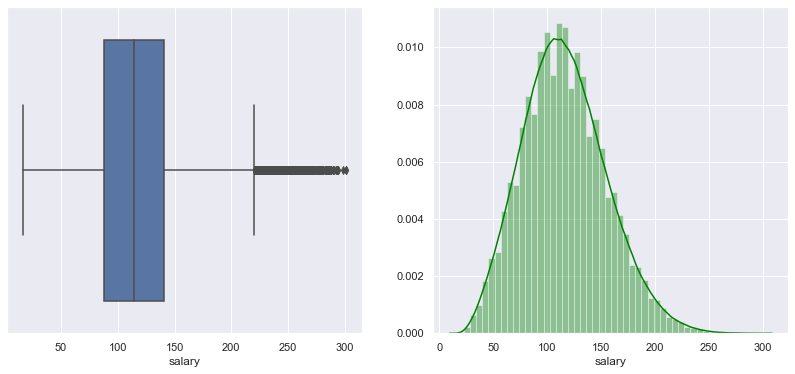

In [572]:
# Visualize target variable (salary).
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(train_df.salary)
plt.subplot(1,2,2)
sns.distplot(train_df.salary, bins=50 , color = 'green')
plt.show()

##### From initially observing the data graphically, it appears that there are outliers on the upper end (invalid zero entries have been removed, these would have been lower end outliers). My next action based on this insight is to use summary statistics and calculated IQR to delve into the outliers further.

In [573]:
# Generate summary statistics and IQR for the training data train_df. Use IQR to calculate the upper and lower limits.
train_df.salary.describe()
summary_stats = train_df.salary.describe()
print(summary_stats)
IQR = summary_stats['75%'] - summary_stats['25%']
upper = summary_stats['75%'] + 1.5 * IQR
lower = summary_stats['25%'] - 1.5 * IQR
print('The upper and lower limits calculated to confirm suspected outliers are {} and {}.'.format(upper, lower))

count    999995.000000
mean        116.062398
std          38.717163
min          17.000000
25%          88.000000
50%         114.000000
75%         141.000000
max         301.000000
Name: salary, dtype: float64
The upper and lower limits calculated to confirm suspected outliers are 220.5 and 8.5.


##### The summary statistics allow us to access the 25th and 75th percentiles of the salary column of train_df. IQR is calculated and presented above by subtracting the 75th percentile from the 25th percentile value. The IQR value is then used to calculate the lower limit and the upper limit of the salary column data, any data lying outside of these limits can be considered an outlier.

In [574]:
# Confirm for sure that there are no outliers (rows) equal to or below the lower limit.
train_df[train_df.salary < 8.5]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary


In [575]:
# Filter the train_df dataframe to show the rows that contain a salary more than the upper limit. 
train_df[train_df.salary > 220.5]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
266,JOB1362684407953,COMP30,CEO,MASTERS,BIOLOGY,OIL,23,60,223
362,JOB1362684408049,COMP38,CTO,MASTERS,NONE,HEALTH,24,3,223
560,JOB1362684408247,COMP53,CEO,MASTERS,BIOLOGY,WEB,22,7,248
670,JOB1362684408357,COMP26,CEO,MASTERS,MATH,AUTO,23,9,240
719,JOB1362684408406,COMP54,VICE_PRESIDENT,DOCTORAL,BIOLOGY,OIL,21,14,225
966,JOB1362684408653,COMP32,CEO,DOCTORAL,ENGINEERING,FINANCE,23,11,247
986,JOB1362684408673,COMP37,CFO,HIGH_SCHOOL,NONE,FINANCE,24,20,229
1211,JOB1362684408898,COMP24,CTO,DOCTORAL,BUSINESS,FINANCE,5,46,232
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
1413,JOB1362684409100,COMP56,VICE_PRESIDENT,MASTERS,MATH,WEB,24,15,241


In [576]:
# Calculate the upper limit outliers count as a percentage of the salary count (calculate salary and outlier count first).
training_salary_count = train_df.salary.count()
upper_outliers_count = train_df[train_df.salary > 220.5].salary.count()
upper_outlier_percentage = upper_outliers_count / training_salary_count * 100
upper_outlier_percentage = upper_outlier_percentage.round(2)
print('The upper outliers count ({}) is {}% of the salary count ({}).'.format(upper_outliers_count, upper_outlier_percentage, training_salary_count))

The upper outliers count (7117) is 0.71% of the salary count (999995).


##### The upper outliers constitute 0.71% of the data. This is a relatively low volume of data (7117 rows), given the large data set we have (999995 rows). My next course of action is to remove the outlier rows in an effort to increase the quality of the predictions going forward. For guidance on my thought process and justification for removing the outliers see https://humansofdata.atlan.com/2018/03/when-delete-outliers-dataset/.

In [577]:
# Remove the upper outliers from the training data, reindex the training data and output head and tail to confirm rows have been dropped.
# Drop jobId column as it is a unique identifier and will not contribute to prediction going forward
train_df = train_df[train_df.salary <= 220.5]
train_df.drop('jobId', axis=1, inplace=True)
train_df = train_df.reset_index(drop=True)
ends(train_df, 3)

992878 rows x 8 columns


,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
992875,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
992876,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149
992877,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11,88


##### Data cleansing steps are complete. Invalid data has been removed and outlier analysis and removal has been carried out.

### Explore the data (EDA)

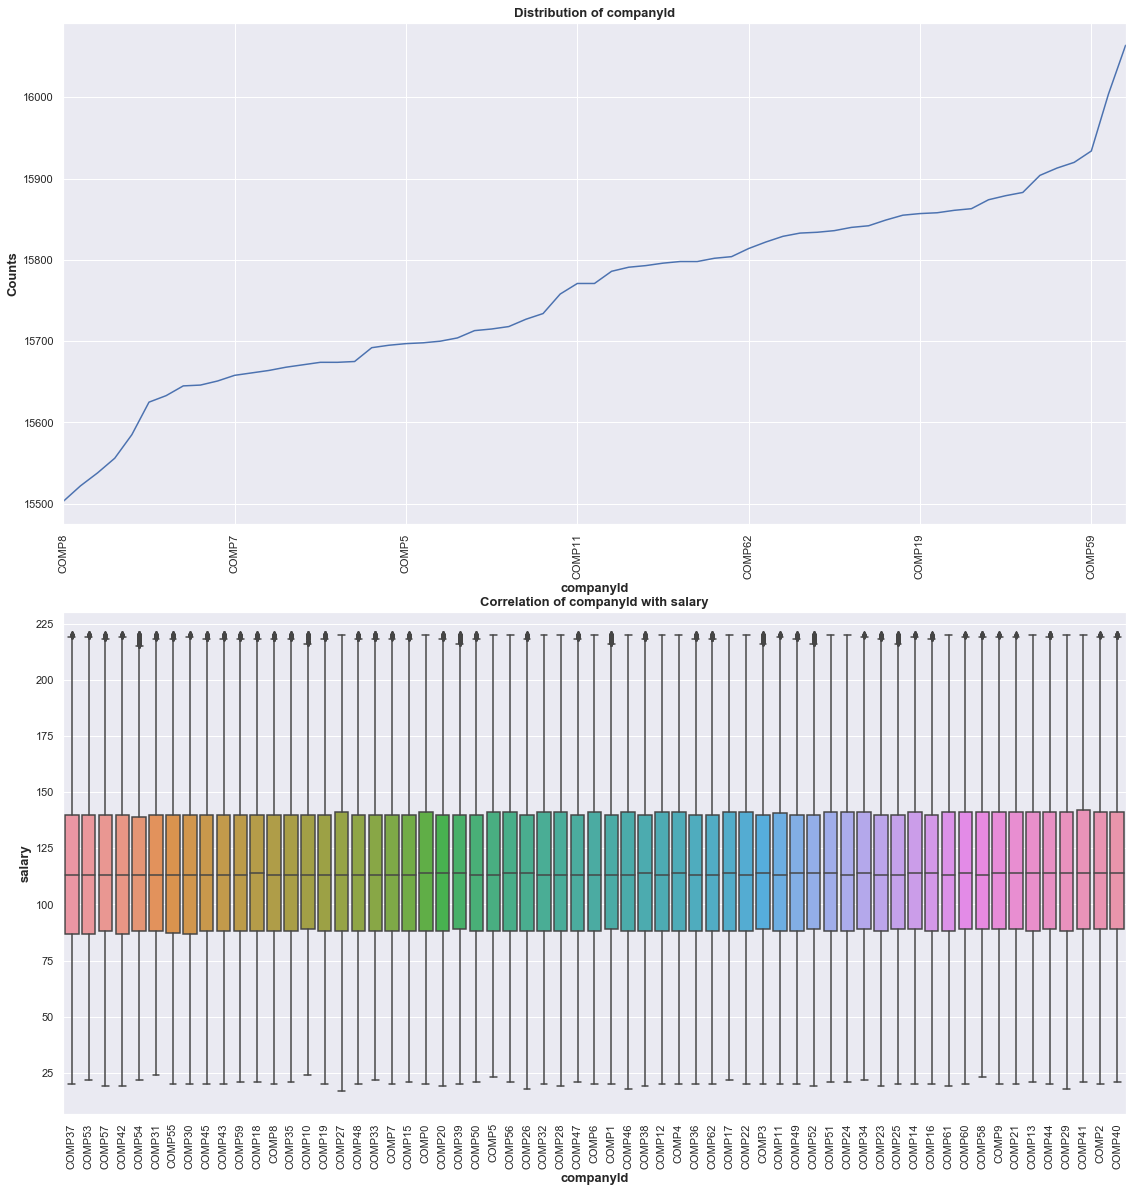

In [578]:
plot_feature(train_df,'companyId','salary')

##### The plots for companyId illustrate that there is no correlation between companyId and salary. The IQR's are similar across companies. This suggests companyId would not be a candidate for predicting salary.

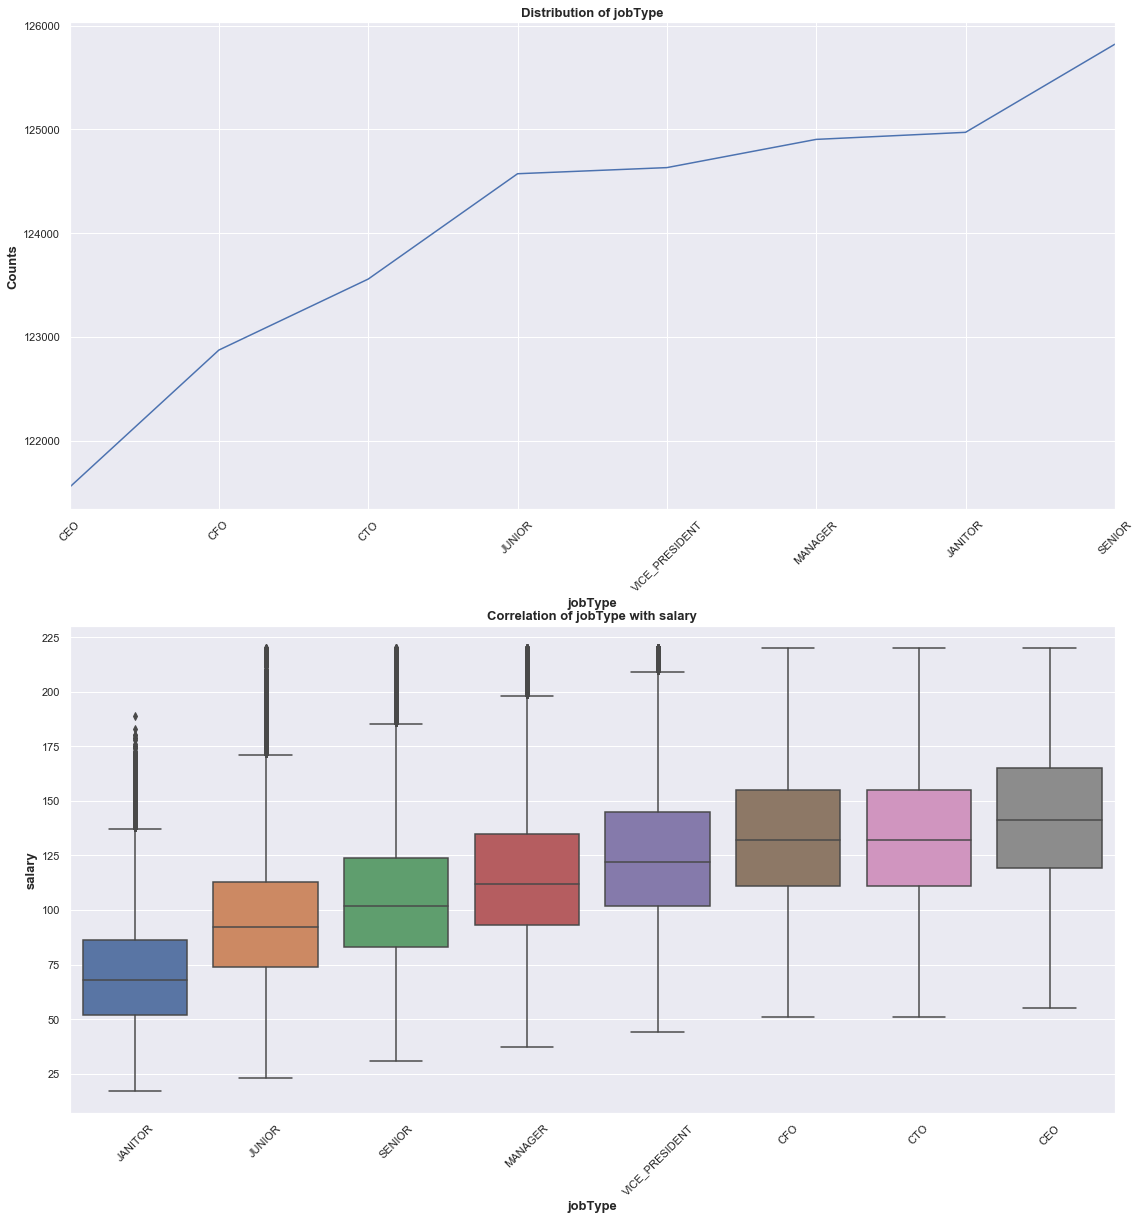

In [579]:
plot_feature(train_df,'jobType','salary')

##### The plots for jobType illustrate that there is a correlation between jobType and salary. The IQR's differ across jobTypes. As perhaps expected, CEO are paid highest (at the top of the IQR) and janitors are paid least (at the bottom of the IQR). Salary appears to adhere to jobType seniority, this suggests jobType may be a good candidate for predicting salary.

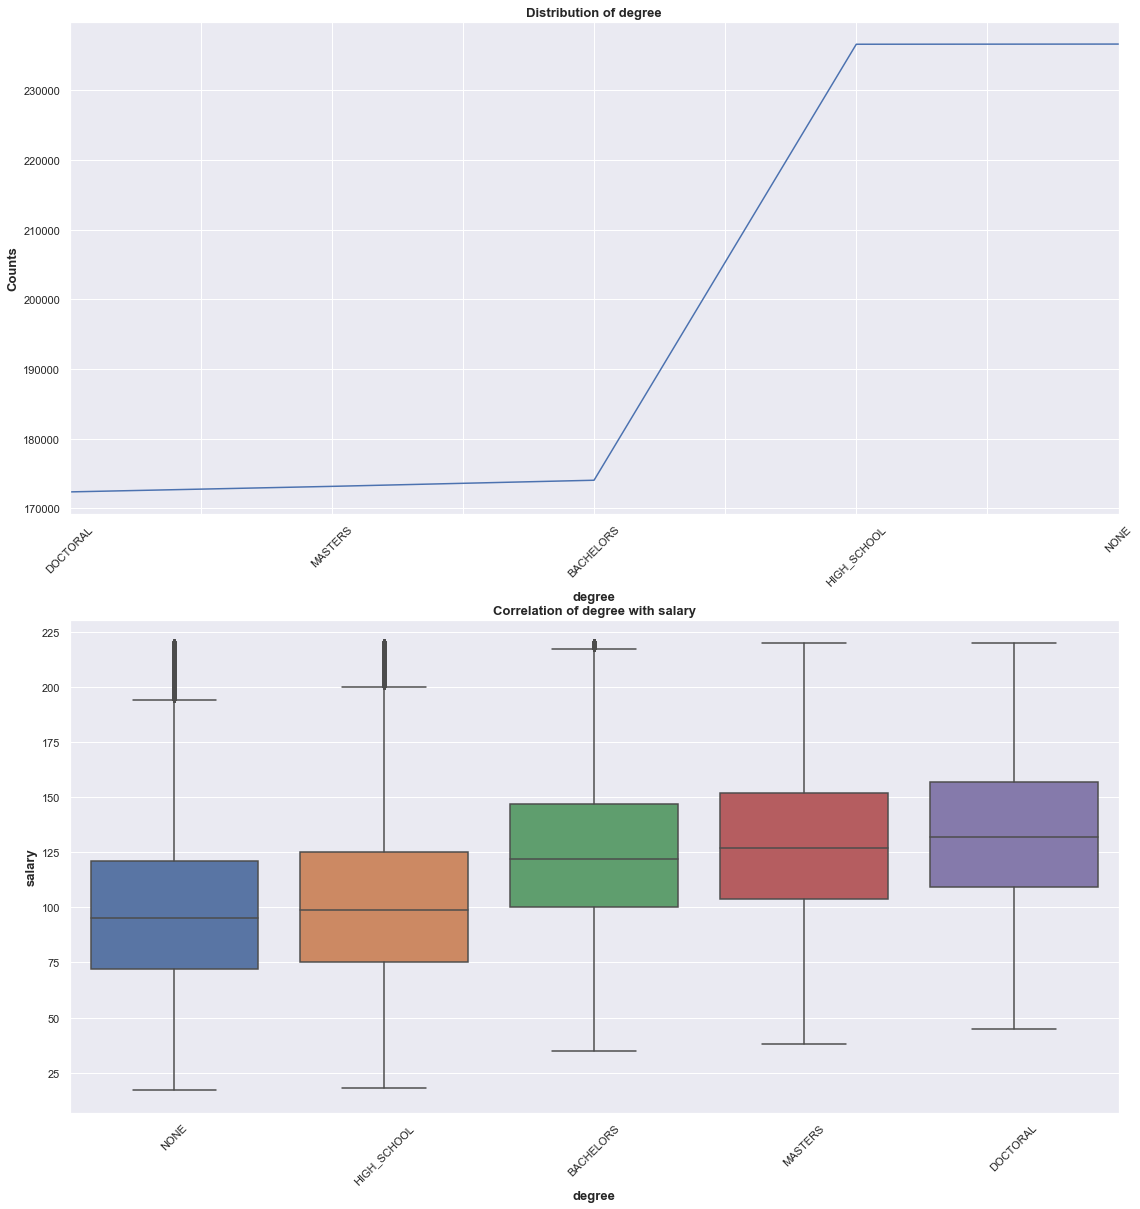

In [580]:
plot_feature(train_df,'degree','salary')

##### The plots for degree illustrate that there is a correlation between degree and salary. The IQR's differ across degree. Doctoral level employees are paid highest (at the top of the IQR) and employees without a degree are paid least (at the bottom of the IQR - only a little lower than high school educated employees). Salary appears to adhere to education level, this suggests degree may be a good candidate for predicting salary.

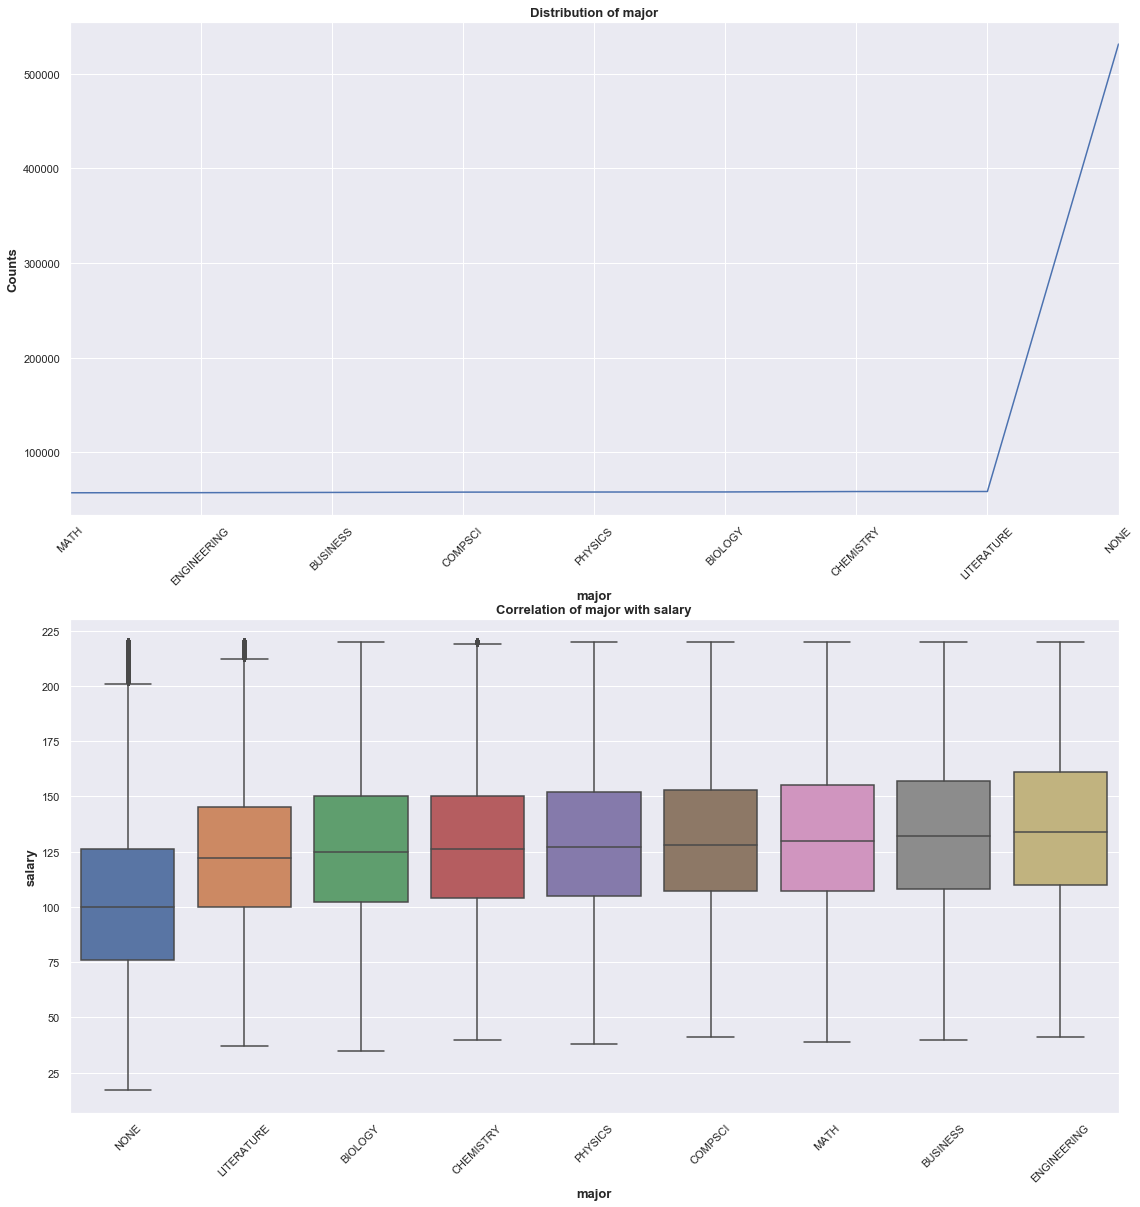

In [581]:
plot_feature(train_df,'major','salary')

##### The plots for major illustrate that there is a correlation between major and salary. The IQR's differ across major. Engineering major employees are paid highest (at the top of the IQR) and employees without a major are paid least (at the bottom of the IQR - unclear whether this is empoyees with degrees without majors, without degrees or a combination of both). Given the relatively low variation between major salary IQR's however, it may be worth combining degree and major to a single variable.

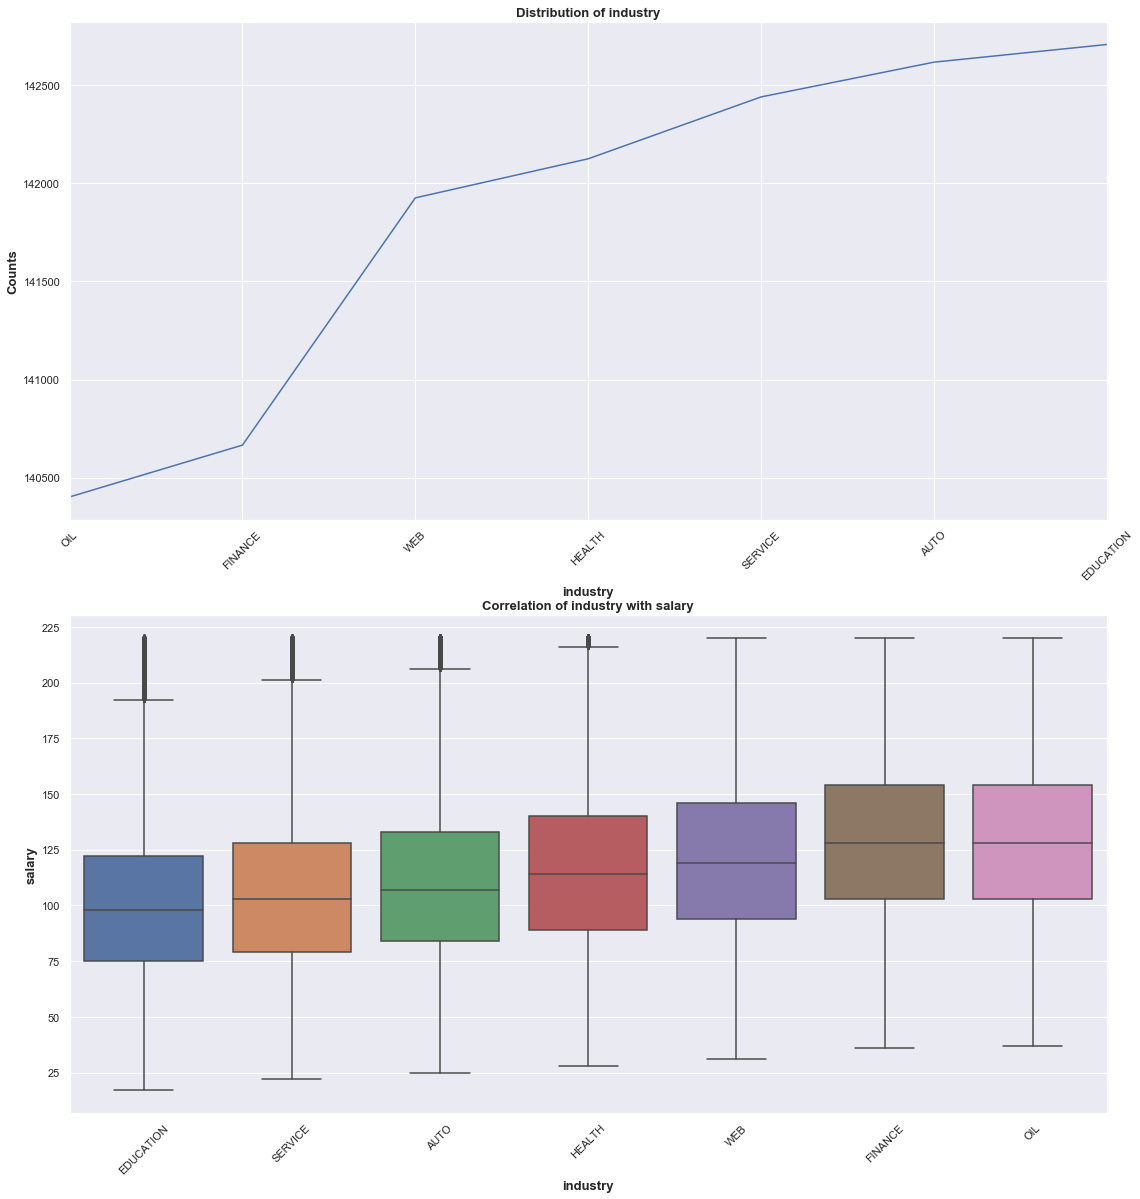

In [582]:
plot_feature(train_df,'industry','salary')

##### The plots for industry illustrate that there is a correlation between industry and salary. The IQR's differ across industry. Oil, and finance employees are paid highest (at the top of the IQR) and employees in education are paid least (at the bottom of the IQR. This notable differences between industry suggest it may be a good candidate for predicting salary.

In [583]:
# plot_feature(train_df,'yearsExperience','salary')

##### The plots for yearsExperience illustrate that there is a correlation between yearsExperience and salary. The trend is that the mean salary increases as yearsExperience increase. This suggests that yearsExperience may be a good candidate for predicting salary.

In [584]:
# plot_feature(train_df,'milesFromMetropolis','salary')

##### The plots for milesFromMetropolis illustrate that there is a correlation between milesFromMetropolis and salary. The trend is that the mean salary decreases as milesFromMetropolis increase. This suggests that milesFromMetropolis may be a good candidate for predicting salary.

In [585]:
# Based on the above analysis, companyId will be dropped, as it will not be taken forward as a feature for prediction.
train_df.drop('companyId', axis=1, inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992878 entries, 0 to 992877
Data columns (total 7 columns):
jobType                992878 non-null object
degree                 992878 non-null object
major                  992878 non-null object
industry               992878 non-null object
yearsExperience        992878 non-null int64
milesFromMetropolis    992878 non-null int64
salary                 992878 non-null int64
dtypes: int64(3), object(4)
memory usage: 53.0+ MB


In [586]:
# Also based on the above analysis, degree and major will be combined (major and degree columns will be dropped and degree_major will be added)
train_df['degree_major'] = train_df[['degree', 'major']].apply(lambda x: '_'.join(x), axis=1)
train_df.drop(['degree', 'major'], axis=1, inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992878 entries, 0 to 992877
Data columns (total 6 columns):
jobType                992878 non-null object
industry               992878 non-null object
yearsExperience        992878 non-null int64
milesFromMetropolis    992878 non-null int64
salary                 992878 non-null int64
degree_major           992878 non-null object
dtypes: int64(3), object(3)
memory usage: 45.5+ MB


##### Now dummy variables will be assigned to categorical data ('one-hot encoding') so it can be used in prediction models.

In [587]:
# One hot encode categorical variables and assign to train_df.
train_df = pd.get_dummies(train_df, sparse=True)

In [588]:
# Confirm one hot encoding has taken place.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992878 entries, 0 to 992877
Data columns (total 47 columns):
yearsExperience                       -992878 non-null int64
milesFromMetropolis                   -992878 non-null int64
salary                                -992878 non-null int64
jobType_CEO                           -992878 non-null Sparse[uint8, 0]
jobType_CFO                           -992878 non-null Sparse[uint8, 0]
jobType_CTO                           -992878 non-null Sparse[uint8, 0]
jobType_JANITOR                       -992878 non-null Sparse[uint8, 0]
jobType_JUNIOR                        -992878 non-null Sparse[uint8, 0]
jobType_MANAGER                       -992878 non-null Sparse[uint8, 0]
jobType_SENIOR                        -992878 non-null Sparse[uint8, 0]
jobType_VICE_PRESIDENT                -992878 non-null Sparse[uint8, 0]
industry_AUTO                         -992878 non-null Sparse[uint8, 0]
industry_EDUCATION                    -992878 non-null Spa

In [589]:
# Look at the head and tail of train_df_cat to confirm that encoding has taken place.
ends(train_df, 3)

992878 rows x 47 columns


,yearsExperience,milesFromMetropolis,salary,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,...,degree_major_MASTERS_BIOLOGY,degree_major_MASTERS_BUSINESS,degree_major_MASTERS_CHEMISTRY,degree_major_MASTERS_COMPSCI,degree_major_MASTERS_ENGINEERING,degree_major_MASTERS_LITERATURE,degree_major_MASTERS_MATH,degree_major_MASTERS_NONE,degree_major_MASTERS_PHYSICS,degree_major_NONE_NONE
0,10,83,130,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,3,73,101,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10,38,137,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
992875,16,81,64,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
992876,6,5,149,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
992877,20,11,88,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


,yearsExperience,milesFromMetropolis,salary,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,...,degree_major_MASTERS_BIOLOGY,degree_major_MASTERS_BUSINESS,degree_major_MASTERS_CHEMISTRY,degree_major_MASTERS_COMPSCI,degree_major_MASTERS_ENGINEERING,degree_major_MASTERS_LITERATURE,degree_major_MASTERS_MATH,degree_major_MASTERS_NONE,degree_major_MASTERS_PHYSICS,degree_major_NONE_NONE
yearsExperience,1.000000,0.008685,0.364983,-0.007016,-0.002417,-0.001146,0.001828,0.002930,0.001898,0.002977,...,-0.000988,-0.000756,-0.000842,-0.001238,-0.002954,0.000236,-0.002004,0.000395,-0.000470,0.003706
milesFromMetropolis,0.008685,1.000000,-0.286955,0.005773,0.002581,0.002626,-0.003834,-0.000895,-0.002304,-0.001879,...,0.000704,0.001381,-0.000145,0.000402,0.001903,0.002150,0.000642,-0.000299,0.000564,-0.004359
salary,0.364983,-0.286955,1.000000,0.275709,0.190817,0.191774,-0.449114,-0.200937,-0.000470,-0.099414,...,0.043418,0.069775,0.048506,0.060237,0.076294,0.031573,0.061718,0.027526,0.053712,-0.255765
jobType_CEO,-0.007016,0.005773,0.275709,1.000000,-0.140364,-0.140810,-0.141728,-0.141469,-0.141684,-0.142279,...,0.007150,0.004884,0.004815,0.008857,0.004447,0.007326,0.006233,0.008862,0.007993,-0.030267
jobType_CFO,-0.002417,0.002581,0.190817,-0.140364,1.000000,-0.141681,-0.142605,-0.142345,-0.142561,-0.143159,...,0.007505,0.006985,0.009653,0.009201,0.007097,0.005596,0.007544,0.008608,0.008818,-0.033113
jobType_CTO,-0.001146,0.002626,0.191774,-0.140810,-0.141681,1.000000,-0.143058,-0.142796,-0.143013,-0.143613,...,0.007748,0.008007,0.008102,0.008753,0.007812,0.009020,0.008441,0.008051,0.006764,-0.032956
jobType_JANITOR,0.001828,-0.003834,-0.449114,-0.141728,-0.142605,-0.143058,1.000000,-0.143728,-0.143946,-0.144550,...,-0.053265,-0.053215,-0.053613,-0.053366,-0.053032,-0.053783,-0.052860,-0.053300,-0.053664,0.233452
jobType_JUNIOR,0.002930,-0.000895,-0.200937,-0.141469,-0.142345,-0.142796,-0.143728,1.000000,-0.143683,-0.144286,...,0.007244,0.008828,0.006913,0.005422,0.008707,0.008792,0.008849,0.006640,0.007137,-0.035038
jobType_MANAGER,0.001898,-0.002304,-0.000470,-0.141684,-0.142561,-0.143013,-0.143946,-0.143683,1.000000,-0.144505,...,0.008683,0.008346,0.006654,0.007212,0.008290,0.008662,0.007677,0.007616,0.009506,-0.033343
jobType_SENIOR,0.002977,-0.001879,-0.099414,-0.142279,-0.143159,-0.143613,-0.144550,-0.144286,-0.144505,1.000000,...,0.007980,0.008393,0.009038,0.007524,0.009710,0.007849,0.006402,0.007400,0.007205,-0.034615


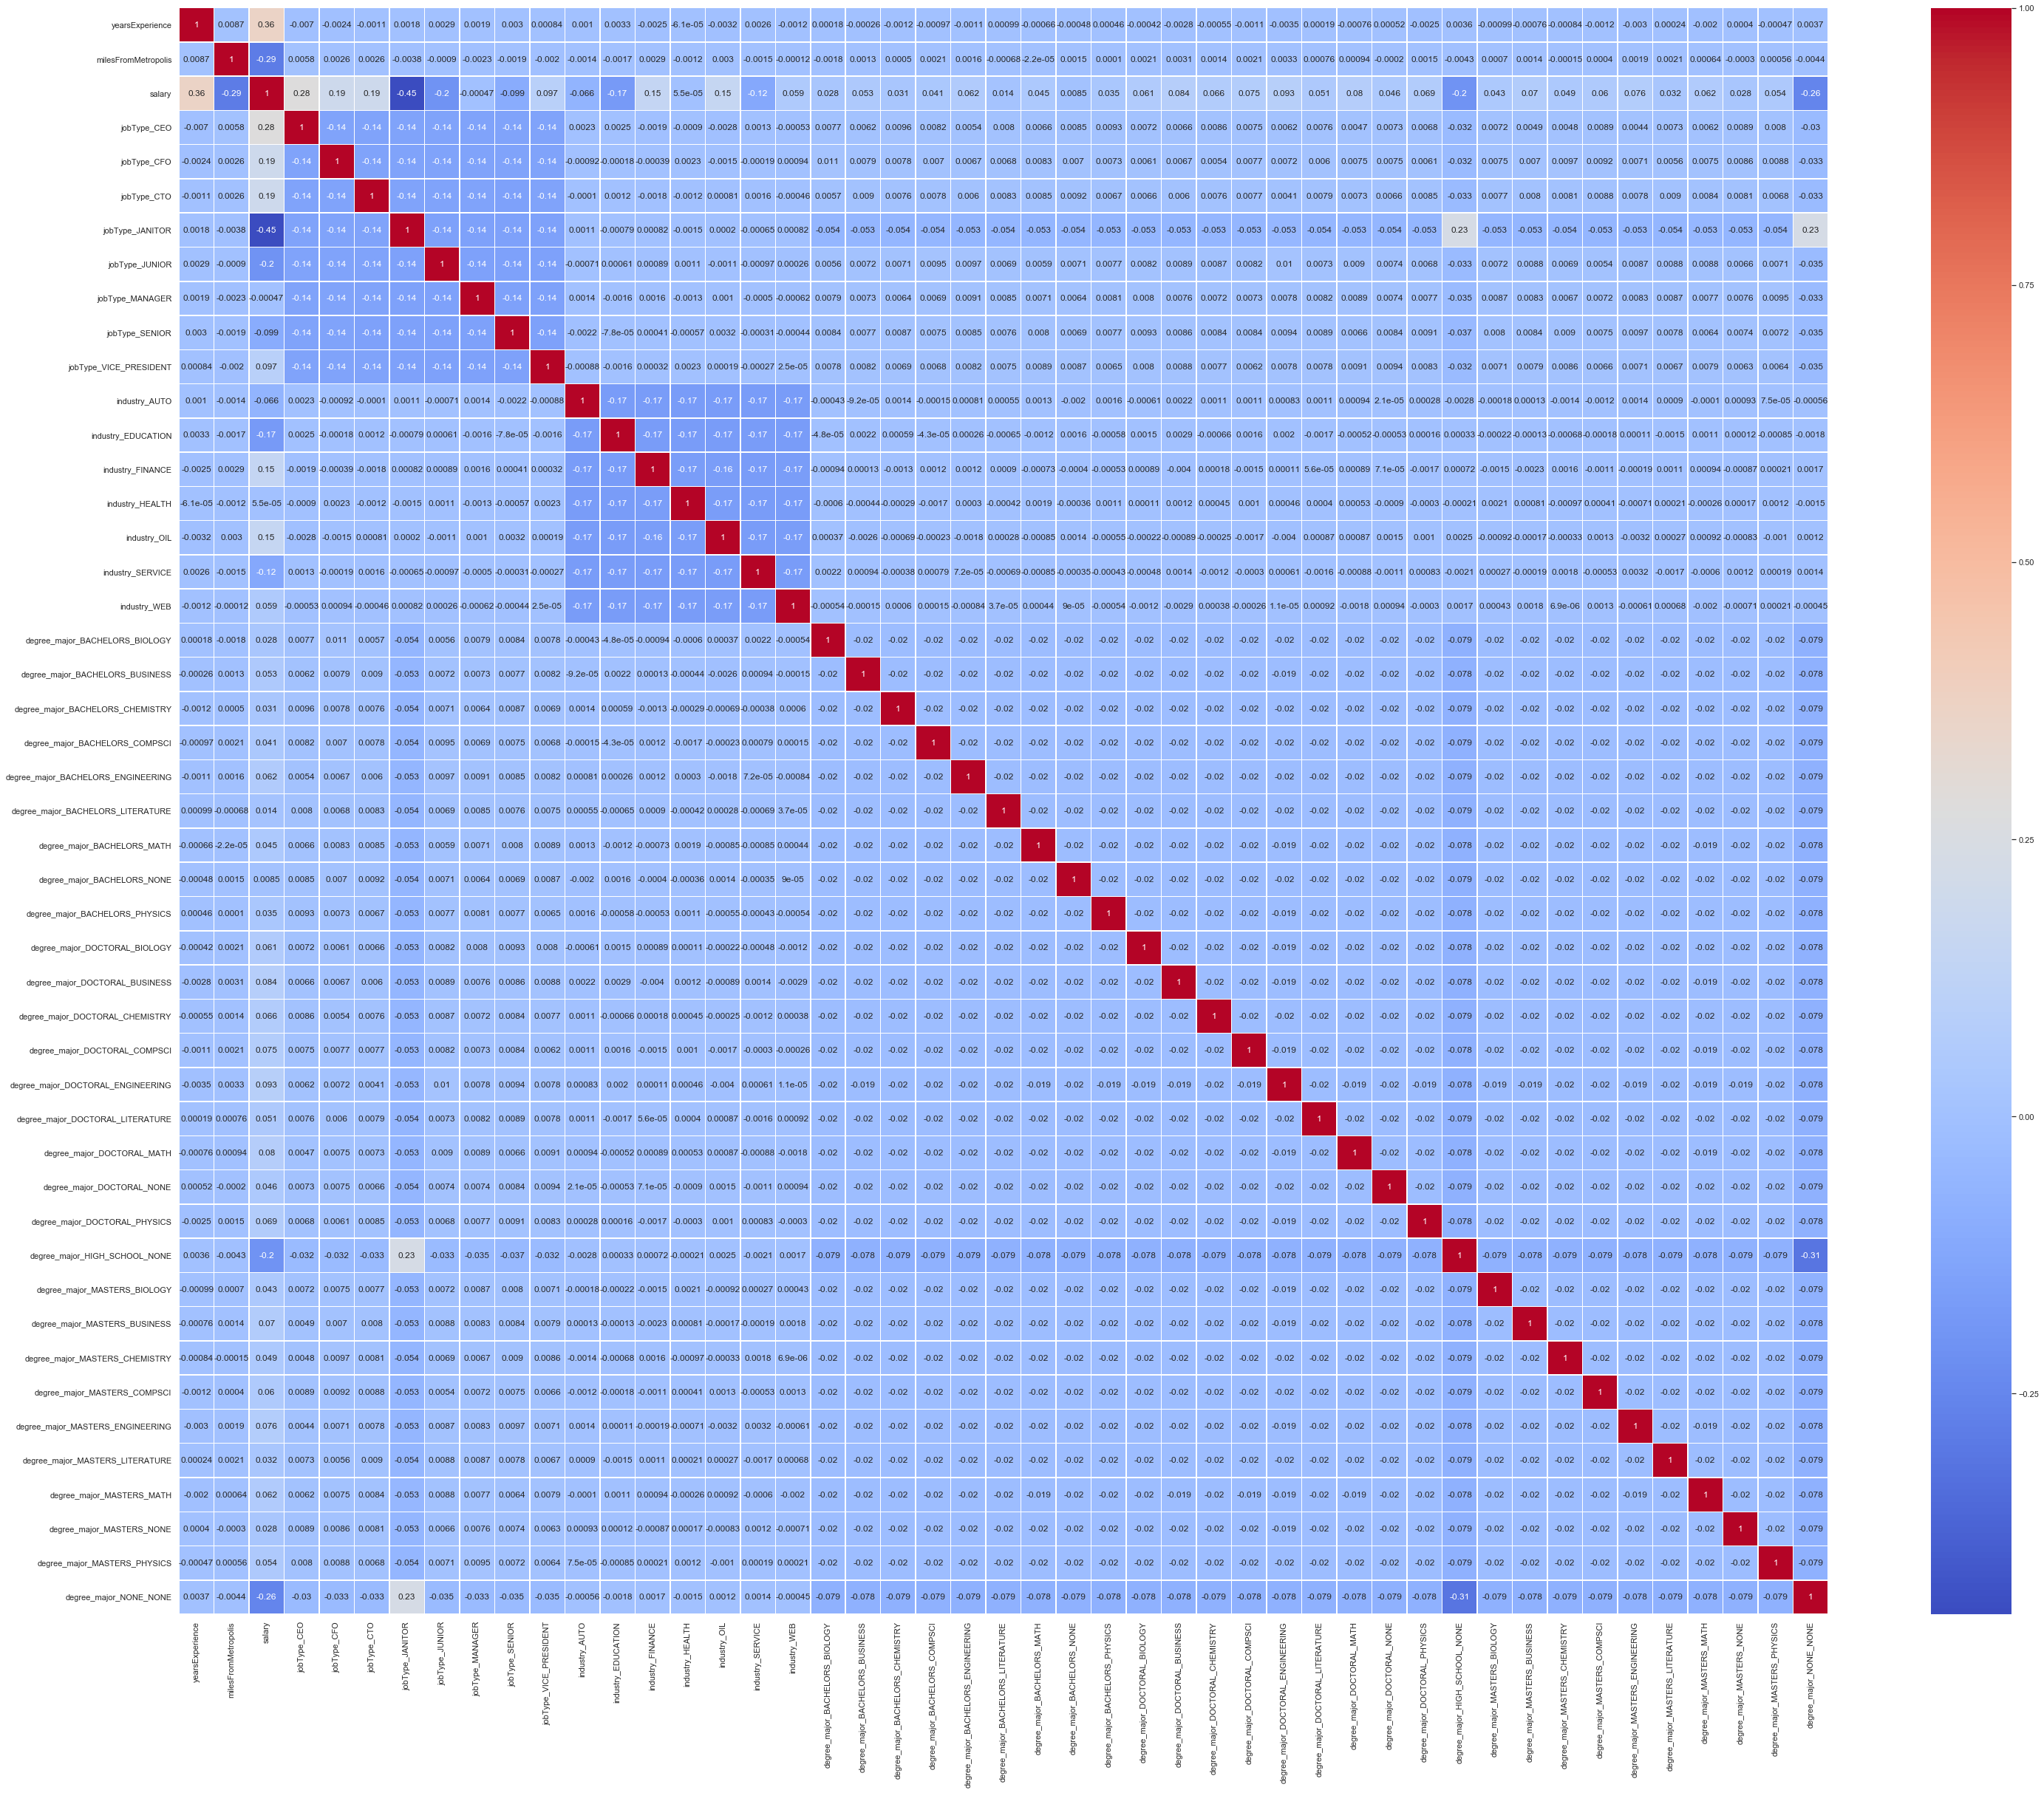

In [590]:
# Using train_df_cat, produce a heatmap to observe the correlation between features.
plt.figure(figsize=(50,40))
c_matrix = train_df.corr()
sns.heatmap(c_matrix,cmap='coolwarm',annot=True, linewidth=0.5)
c_matrix

In [591]:
# Use get_top_correlation function to get top 5 correlated pairs as a condensed indication of best correlated pairs of variables.
get_top_correlations(train_df)

Top 5 Correlated Pairs


salary                         jobType_JANITOR           0.449114
yearsExperience                salary                    0.364983
degree_major_HIGH_SCHOOL_NONE  degree_major_NONE_NONE    0.312905
milesFromMetropolis            salary                    0.286955
salary                         jobType_CEO               0.275709
dtype: float64

##### From the analysis of 'feature v feature' and 'target v features', it appears that the most highly correlated general features to salary are yearsExperience and milesFromMetropolis.

##### It is also notable that there are a number of the 'jobType_' categories that are highly correlated with salary in the top 5. 

In [592]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992878 entries, 0 to 992877
Data columns (total 47 columns):
yearsExperience                       -992878 non-null int64
milesFromMetropolis                   -992878 non-null int64
salary                                -992878 non-null int64
jobType_CEO                           -992878 non-null Sparse[uint8, 0]
jobType_CFO                           -992878 non-null Sparse[uint8, 0]
jobType_CTO                           -992878 non-null Sparse[uint8, 0]
jobType_JANITOR                       -992878 non-null Sparse[uint8, 0]
jobType_JUNIOR                        -992878 non-null Sparse[uint8, 0]
jobType_MANAGER                       -992878 non-null Sparse[uint8, 0]
jobType_SENIOR                        -992878 non-null Sparse[uint8, 0]
jobType_VICE_PRESIDENT                -992878 non-null Sparse[uint8, 0]
industry_AUTO                         -992878 non-null Sparse[uint8, 0]
industry_EDUCATION                    -992878 non-null Spa

### ---- 5 Establish a baseline ----

In [602]:
# Creating baseline values
features = train_df.drop("salary",axis=1)
target = train_df.salary


#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

0         130
1         101
2         137
3         142
4         163
5         113
6         178
7          73
8          31
9         104
10        102
11        144
12         79
13        193
14         47
15        172
16         47
17        126
18        122
19         95
20         32
21         68
22        105
23         76
24        202
25        131
26        158
27        130
28        101
29         82
         ... 
992848    216
992849    115
992850     56
992851    117
992852    131
992853     97
992854    112
992855    142
992856     93
992857    181
992858     84
992859    132
992860    113
992861    122
992862    110
992863    147
992864    117
992865    124
992866     79
992867     72
992868     89
992869    139
992870    143
992871    136
992872    115
992873     88
992874    160
992875     64
992876    149
992877     88
Name: salary, Length: 992878, dtype: int64


### ---- 6 Hypothesize solution ----

In [594]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [595]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [596]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [597]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [598]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [599]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [600]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data